In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

2025-05-12 11:10:54.288749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 11:10:54.518386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747028454.597771     934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747028454.619129     934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747028454.770241     934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

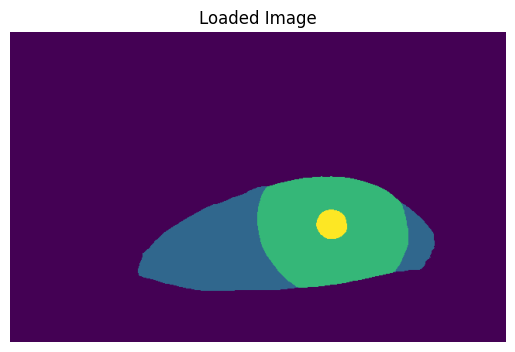

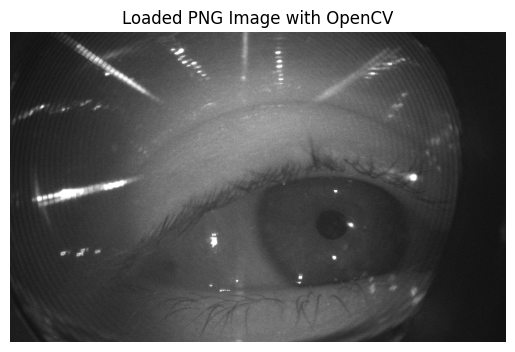

In [4]:
# Load the .npy file
label_file_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels/000010.npy'
image_file_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000010.png'

image_label = np.load(label_file_path)

# Display the image
plt.imshow(image_label)  # or remove cmap='gray' for a color image if applicable
plt.title('Loaded Image')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

img = cv2.imread(image_file_path)

# OpenCV loads images in BGR format by default, so we convert it to RGB for correct display
img_rgb = cv2.cvtColor(img, cv2.IMREAD_COLOR)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.title('Loaded PNG Image with OpenCV')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

In [5]:
def load_images_label_pairs(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    count = 0
    for img, label in zip(image_files, label_files):
        count += 1
        if(count in currupted_images):
            continue
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        img = cv2.resize(img, (128, 128))  # Resize if needed
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)

    return np.array(images), np.array(labels)


In [6]:
image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images'
label_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels'
images, labels = load_images_label_pairs(image_dir_path, label_dir_path)

# # Normalize the images and labels
images = images / 255.0  # Normalize images between [0, 1]
labels = labels / np.max(labels)  # Normalize labels between [0, 1]

Images count: 2744


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Print the shapes of the resulting datasets
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")



Training images shape: (2192, 128, 128)
Training labels shape: (2192, 128, 128)
Testing images shape: (549, 128, 128)
Testing labels shape: (549, 128, 128)


In [6]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the U-Net model
unet = unet_model(input_size=(128, 128, 1))
unet.summary()

I0000 00:00:1745925643.842522   98412 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         65 │ batch_normalizat

 Total params: 904,129 (3.45 MB)

 Trainable params: 903,361 (3.45 MB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
history = unet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # You can adjust the number of epochs
    batch_size=4,  # You can adjust the batch size
    shuffle=True
)

# Save the trained model
unet.save('unet_gaze_estimation_model.h5')

Epoch 1/50


I0000 00:00:1745925662.388259   98608 service.cc:152] XLA service 0x7fe0b40195e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745925662.389180   98608 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-29 16:51:02.531683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745925663.040430   98608 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/548 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.3925 - loss: 1.0298  

I0000 00:00:1745925669.479742   98608 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8029 - loss: 0.3505 - val_accuracy: 0.8603 - val_loss: 0.1728
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8603 - loss: 0.1109 - val_accuracy: 0.8622 - val_loss: 0.1204
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8608 - loss: 0.1004 - val_accuracy: 0.8620 - val_loss: 0.0970
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8594 - loss: 0.0981 - val_accuracy: 0.8620 - val_loss: 0.0973
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8613 - loss: 0.0946 - val_accuracy: 0.8615 - val_loss: 0.1402
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8609 - loss: 0.0948 - val_accuracy: 0.8561 - val_loss: 0.2302
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8618 - loss: 0.0942 - val_accuracy: 0.8620 - val_loss: 0.0944
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8619 - loss: 0.0921 - val_accurac

NameError: name 'history' is not defined

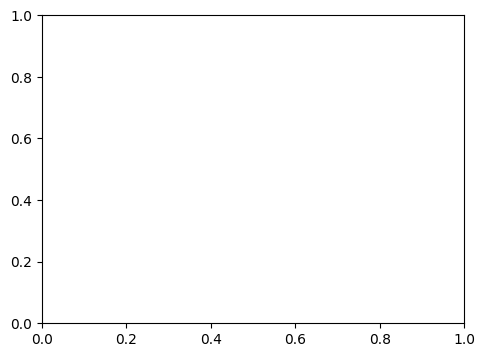

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

I0000 00:00:1747028757.751268     934 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747028759.051314    3131 service.cc:152] XLA service 0x7f5e9c00ade0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747028759.051377    3131 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-12 11:15:59.074230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747028759.152396    3131 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1747028760.417163    3131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


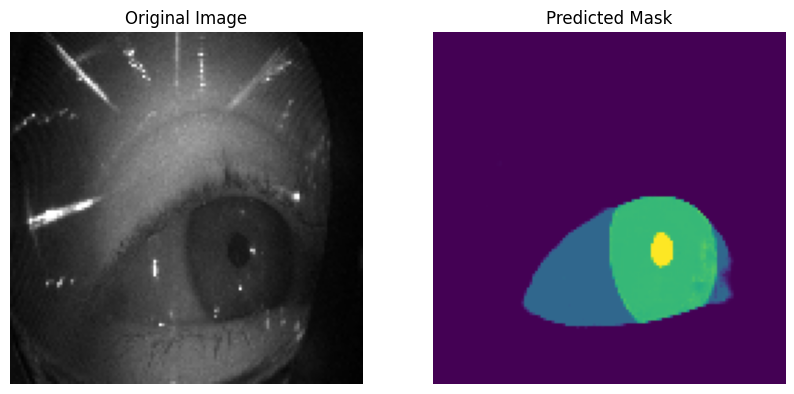

In [8]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained U-Net model
model = tf.keras.models.load_model('unet_gaze_estimation_model.h5')

# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000000.png'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (128, 128))

# Normalize the image to the [0, 1] range
image_normalized = image_resized/255

# Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


In [10]:

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
light_unet = lightweight_unet_model(input_size=(128, 128, 1))
light_unet.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Print training set size
print(f"Training samples: {len(X_train)}")

# Train the model
history = light_unet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # <-- Fixed here
    epochs=50,
    batch_size=4,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)

# Save the model
light_unet.save('light_weight_unet_gaze_estimation_model.h5')  # <-- Typo fixed


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     32,832 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 128, 128,  │      8,224 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     18,464 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │         33 │ batch_normalizat

 Total params: 226,785 (885.88 KB)

 Trainable params: 226,401 (884.38 KB)

 Non-trainable params: 384 (1.50 KB)

Training samples: 2192
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8038 - loss: 0.3599 - val_accuracy: 0.8605 - val_loss: 0.1517 - learning_rate: 0.0010
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8609 - loss: 0.1067 - val_accuracy: 0.8619 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8621 - loss: 0.0989 - val_accuracy: 0.8610 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8603 - loss: 0.0974 - val_accuracy: 0.8617 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8601 - loss: 0.0966 - val_accuracy: 0.8622 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8609 - loss: 0.0944 - val_accuracy: 0.8621 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


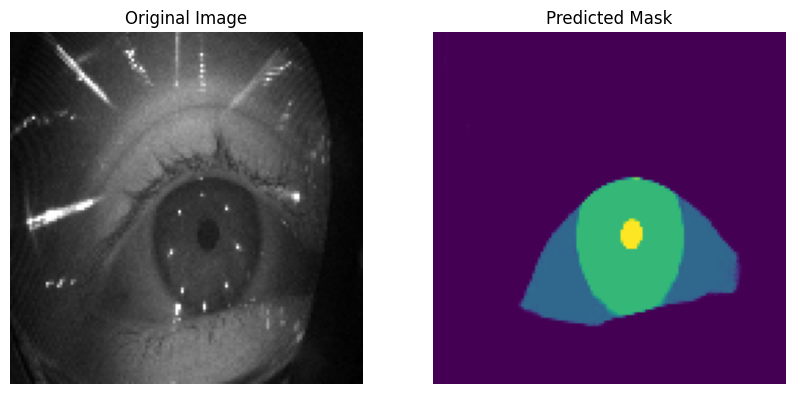

In [9]:
# Re-define dice_loss again (important!)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})


# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/S_0/0.png'

# image_path = '/home/yasas/GazeEstimation/412.jpg'


# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (128, 128))

# Normalize the image to the [0, 1] range
image_normalized = image_resized/255

# # Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [ ]:
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")


def calculate_miou(y_true, y_pred, threshold=0.5):
    """Calculate mIoU manually from predictions"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)
    
    # Initialize IoU array
    ious = []
    
    # Calculate IoU for each image in the batch
    for i in range(len(y_true)):
        # Flatten the masks
        true_mask = y_true[i].flatten()
        pred_mask = y_pred_binary[i].flatten()
        
        # Calculate intersection and union
        intersection = np.sum(true_mask * pred_mask)
        union = np.sum(true_mask) + np.sum(pred_mask) - intersection
        
        # Calculate IoU
        if union > 0:
            iou = intersection / union
        else:
            iou = 1.0  # If both true and pred are empty
        
        ious.append(iou)
    
    # Return mean IoU
    return np.mean(ious)

print(X_test.shape)

y_pred = model.predict(X_test)

# Calculate mIoU manually
miou_score = calculate_miou(y_test, y_pred)
print(f"Manually calculated mIoU: {miou_score}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8622 - loss: 0.0909
Test loss: 0.09089261293411255
Test accuracy: 0.8621982932090759


ValueError: as_list() is not defined on an unknown TensorShape.